In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import gc
import math
from tqdm.notebook import tqdm

In [3]:
#Load Data
transactions = pd.read_csv("./transactions_train.csv") # 50 Mil # 3,5 GB # 2018-2020
articles = pd.read_csv("./articles.csv") # 
customers = pd.read_csv("./customers.csv")

In [4]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [5]:
articles.head()
#customers.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [65]:
import random
random.seed(10)
# Preprocessing - Reducing DATA size
##First 5 days of tansactions
trans_3_months = transactions[transactions['t_dat'].map(lambda x: x < '2018-09-25')]
trans_3_months.sort_values(by='t_dat',ascending = False).head()
popular_customers = trans_3_months['customer_id'].value_counts()

## Get a sample of customers - reduce customer numbers
popular_customers = trans_3_months['customer_id'].value_counts().reset_index(name = 'counts')
popular_customers = popular_customers.sample(n=200,replace=False, random_state=1)
#popular_customers_ = popular_customers[0:100]
## 
cust_and_article = trans_3_months.drop(['sales_channel_id','t_dat','price'], axis=1)
cust_and_article = cust_and_article.drop_duplicates(subset=['customer_id','article_id'])

pop_cust_articles = pd.merge(popular_customers,cust_and_article, left_on = 'index',right_on = 'customer_id',how = 'left')
pop_cust_articles = pop_cust_articles.drop(['index'],axis =1)

# reduce size of articles based on bought articles
bought_articles = pd.merge(pop_cust_articles,articles,on = 'article_id',how = 'left')


cust_and_index_group_name = pd.merge(pop_cust_articles, articles, on='article_id', how='left' )




In [66]:
popular_customers.head()

,index,counts
26039,3bb157c42c53a87335b0d9d682613f22418c44e317956dfead35ba09a05fa2e9,3
26252,1d517e2038683e9fd93e5f74e3f0ac526407b0f73779a7246568f3959b537657,3
47703,c0fd8defa552376d2e535a2c82df121d97f9151fc6239b2837c1a4a2c71e62ba,1
47578,0284ff631c7cd12a725a3dbec4e058e93b742b06de5639eaa3441fe2f76a1f7a,1
23074,65056352e099978d6fd63bf3ad3615ac555dc7f3e59654c907093a0267e870f7,3


In [67]:
# print(popular_customers.head())
# print(cust_and_article.head())
# print(pop_cust_articles.head())
print(bought_articles.head())
# print(cust_and_index_group_name.head())

   counts                                                       customer_id  \
0       3  3bb157c42c53a87335b0d9d682613f22418c44e317956dfead35ba09a05fa2e9   
1       3  3bb157c42c53a87335b0d9d682613f22418c44e317956dfead35ba09a05fa2e9   
2       3  3bb157c42c53a87335b0d9d682613f22418c44e317956dfead35ba09a05fa2e9   
3       3  1d517e2038683e9fd93e5f74e3f0ac526407b0f73779a7246568f3959b537657   
4       1  c0fd8defa552376d2e535a2c82df121d97f9151fc6239b2837c1a4a2c71e62ba   

   article_id  product_code             prod_name  product_type_no  \
0   594630001        594630  Class Landar mixpack               70   
1   688873006        688873                 Gyda!              258   
2   635240001        635240      Gracie Cross Bag               66   
3   708706001        708706          Princess Lea              265   
4   507987001        507987           Stina scarf               80   

  product_type_name  product_group_name  graphical_appearance_no  \
0           Earring         Accessor

In [68]:
# CREATE List of GrouName at its buyers
buyer = []
group_buyer_dic = {}
# result = []
# We loop through article ID
for index_group_name in bought_articles['index_group_name']:
    for index, transaction in bought_articles.iterrows():
            if index_group_name == transaction['index_group_name']:
                if transaction['customer_id'] not in buyer:        
                    buyer.append(transaction['customer_id'])
    
    #print(article_id)   
    #print(buyer)  
    group_buyer_dic[index_group_name] = buyer
    # result.append(article_buyer_dic)
    #new customer Id
    # article_buyer_dic = {}
    buyer = []

In [69]:
df_groupname_buyers= pd.DataFrame(group_buyer_dic.items(), columns=['index_group_name', 'buyers'])

In [70]:
pd.set_option('display.max_colwidth', None)
df_groupname_buyers.head(10)

index_group_name  \
0       Ladieswear   
1          Divided   
2            Sport   
3         Menswear   
4    Baby/Children   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [71]:
print('Sport:')
print(len(df_groupname_buyers['buyers'][0]))
print('Divided:')
print(len(df_groupname_buyers['buyers'][1]))
print('Ladieswear:')
print(len(df_groupname_buyers['buyers'][2]))
print('Menswear:')
print(len(df_groupname_buyers['buyers'][3]))
print('Baby/Children:')
print(len(df_groupname_buyers['buyers'][4]))


Sport:
143
Divided:
82
Ladieswear:
16
Menswear:
18
Baby/Children:
30


In [72]:
# CREATE List of buyer at its group_name idex
group_name_bought_list = []
buyer_group_dic = {}
for customer in pop_cust_articles['customer_id']:
    for index, transaction in bought_articles.iterrows():
         if customer == transaction['customer_id']:
              if transaction['index_group_name'] not in group_name_bought_list:
                  group_name_bought_list.append(transaction['index_group_name'])
    buyer_group_dic[customer] = group_name_bought_list
    group_name_bought_list = []





In [73]:
df_boughtGroups= pd.DataFrame(buyer_group_dic.items(), columns=['customer_id', 'bougth_groups'])
pd.set_option('display.max_colwidth', None)
df_boughtGroups.head(10)

,customer_id,bougth_groups
0,3bb157c42c53a87335b0d9d682613f22418c44e317956dfead35ba09a05fa2e9,[Ladieswear]
1,1d517e2038683e9fd93e5f74e3f0ac526407b0f73779a7246568f3959b537657,[Ladieswear]
2,c0fd8defa552376d2e535a2c82df121d97f9151fc6239b2837c1a4a2c71e62ba,[Divided]
3,0284ff631c7cd12a725a3dbec4e058e93b742b06de5639eaa3441fe2f76a1f7a,[Divided]
4,65056352e099978d6fd63bf3ad3615ac555dc7f3e59654c907093a0267e870f7,"[Divided, Ladieswear]"
5,05e15856ed9f78dbf7fca37cc5200e308ad0e0b589a15e2e01f567b2edb8fd9a,"[Ladieswear, Sport]"
6,6c731c853a6809a75cc3c64f4353c27eab8217b4d1e80fd0f70b01feff4fcdc5,[Ladieswear]
7,e55d87b890ffb082b4cc07b0449c313f0b036f2cd00304d524012ea3e2b5b0eb,"[Ladieswear, Divided]"
8,5c1eb6da58dd951462a9dc8b5b1fe4843df81aa0c7e288db22e241ad6e582b2e,[Ladieswear]
9,f086b97d258a41cb560cfc18d2923b7dedc4270f9dc178d2cd50a3abddea71e0,[Divided]


In [74]:
graph = nx.Graph()
# Nodes are buyers

graph.add_nodes_from(popular_customers['index'])
list(graph.nodes)

#

['3bb157c42c53a87335b0d9d682613f22418c44e317956dfead35ba09a05fa2e9',
 '1d517e2038683e9fd93e5f74e3f0ac526407b0f73779a7246568f3959b537657',
 'c0fd8defa552376d2e535a2c82df121d97f9151fc6239b2837c1a4a2c71e62ba',
 '0284ff631c7cd12a725a3dbec4e058e93b742b06de5639eaa3441fe2f76a1f7a',
 '65056352e099978d6fd63bf3ad3615ac555dc7f3e59654c907093a0267e870f7',
 '05e15856ed9f78dbf7fca37cc5200e308ad0e0b589a15e2e01f567b2edb8fd9a',
 '6c731c853a6809a75cc3c64f4353c27eab8217b4d1e80fd0f70b01feff4fcdc5',
 'e55d87b890ffb082b4cc07b0449c313f0b036f2cd00304d524012ea3e2b5b0eb',
 '5c1eb6da58dd951462a9dc8b5b1fe4843df81aa0c7e288db22e241ad6e582b2e',
 'f086b97d258a41cb560cfc18d2923b7dedc4270f9dc178d2cd50a3abddea71e0',
 '710d432ff302611fcd8855b6ac97a2f6b5a1561499f1cab8bbec0726134fd25b',
 'c695e363bf717872915670e60bb837b7389374be8000cfe4be99e37508aa31cb',
 '01dd44fbd4291837a90bf1002d2d4ce8c473cfb6ddeebe5291a17b5701125e1a',
 'ab81fbd18fb25be5cf910a691351357ace6a35cec1c3252bab492a8046d7f362',
 '2dd8983b40b597c7033c2a0b1ca59481

In [75]:
#EDGES
for customer in popular_customers['index']:
    # Check if customer is an buyer
    for buyers in  df_groupname_buyers['buyers']:
        if customer in buyers:            
            for buyer in buyers:
                if buyer != customer:
                    # print(buyer)
                    # print(customer)
                    # print(True)
                    graph.add_edge(customer, buyer)

In [ ]:
# Removes nodes with no edges  
# graph.remove_nodes_from(list(nx.isolates(graph)))

In [76]:
popular_customers = trans_3_months['customer_id'].value_counts().reset_index(name = 'counts')
popular_customers.head(15)

,index,counts
0,2fdf822dbaad2b983b37e651a982bba24352a92c8a5c4c75be25c771f2af6d13,103
1,a81e0b7657a090198d8138c95fae7db1218305b97bb8fd3f42b8d8e1b6d5b846,100
2,4aa23f5f3013303a7f194972fd68cf5cb04cdc88ab69bee8acf06283e7988e15,80
3,f6fbb1480291047c308f83a25e8e8b1e2c5a44a9390662b1d8435f700b5555db,72
4,3657f79cf5f3622e4506a3a9c91bb610572ad2d34458b12abdd7c06274d1980b,55
5,55e7d8de6acc36f8e77d681ccfab65dd67bae06cd4e2889b44f472f033aca0e8,54
6,05c5685f1301de31ac4463293228f74ba1b3b427dc1a79dbf54f0cf98f242e81,52
7,4043eeb9fb65b1735639ce44efbc5c43d2f9160fb26c8da6d73ed2e211a01fdf,52
8,31287b3d29b025cf00822b66b462a415e9c58d6538562709292c54d2bb6af25a,52
9,4fa96051d6715de656891c600846990aa7e224086969f0c690eec96b4b3fe6eb,51


In [77]:

color_map = []
for node in graph:
    if buyer_group_dic.get(node) == ['Sport']:
        color_map.append('green')
    elif buyer_group_dic.get(node) == ['Menswear']:
        color_map.append('blue')
    elif buyer_group_dic.get(node) == ['Baby/Children']:
        color_map.append('yellow')
    elif buyer_group_dic.get(node) == ['Ladieswear']:
        color_map.append('red')
    elif buyer_group_dic.get(node) == ['Divided']:
        color_map.append('purple')
    elif buyer_group_dic.get(node) == ['Ladieswear', 'Divided'] or buyer_group_dic.get(node) == ['Divided', 'Ladiswear']:
        color_map.append('magenta')
    elif buyer_group_dic.get(node) == ['Ladieswear', 'Menswear'] or buyer_group_dic.get(node) == ['Menswear', 'Ladiswear']:
        color_map.append('orchid')
    elif buyer_group_dic.get(node) == ['Sport', 'Menswear'] or buyer_group_dic.get(node) == ['Menswear', 'Sport']:
        color_map.append('cyan')
    elif buyer_group_dic.get(node) == ['Sport', 'Baby/Children'] or buyer_group_dic.get(node) == ['Baby/Children', 'Sport']:
        color_map.append('orange')
    elif buyer_group_dic.get(node) == ['Divided', 'Menswear'] or buyer_group_dic.get(node) == ['Menswear', 'Divided']:
        color_map.append('chocolate')
    else: 
        color_map.append('black')      


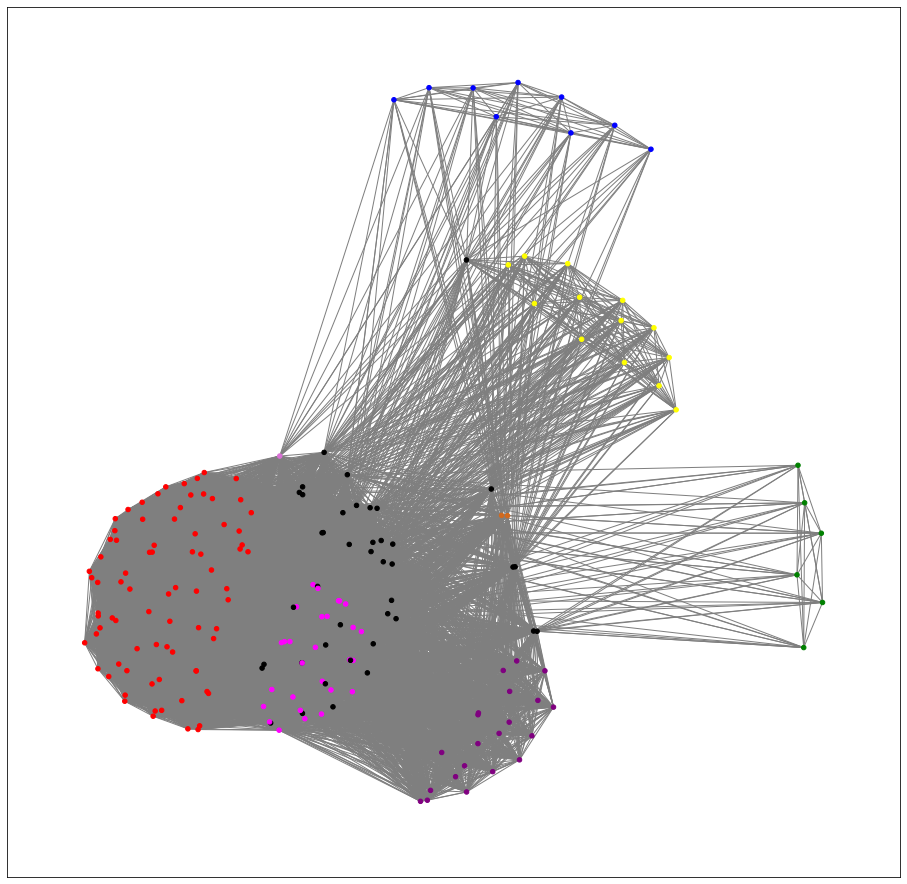

In [78]:

plt.figure(3,figsize=(16,16)) 
cluster = nx.draw_networkx(graph,node_color=color_map, with_labels=False, node_size = 20, edge_color="tab:gray")
plt.show()

# ToDo
# - Delete node which has no edge



# -

# Clustering

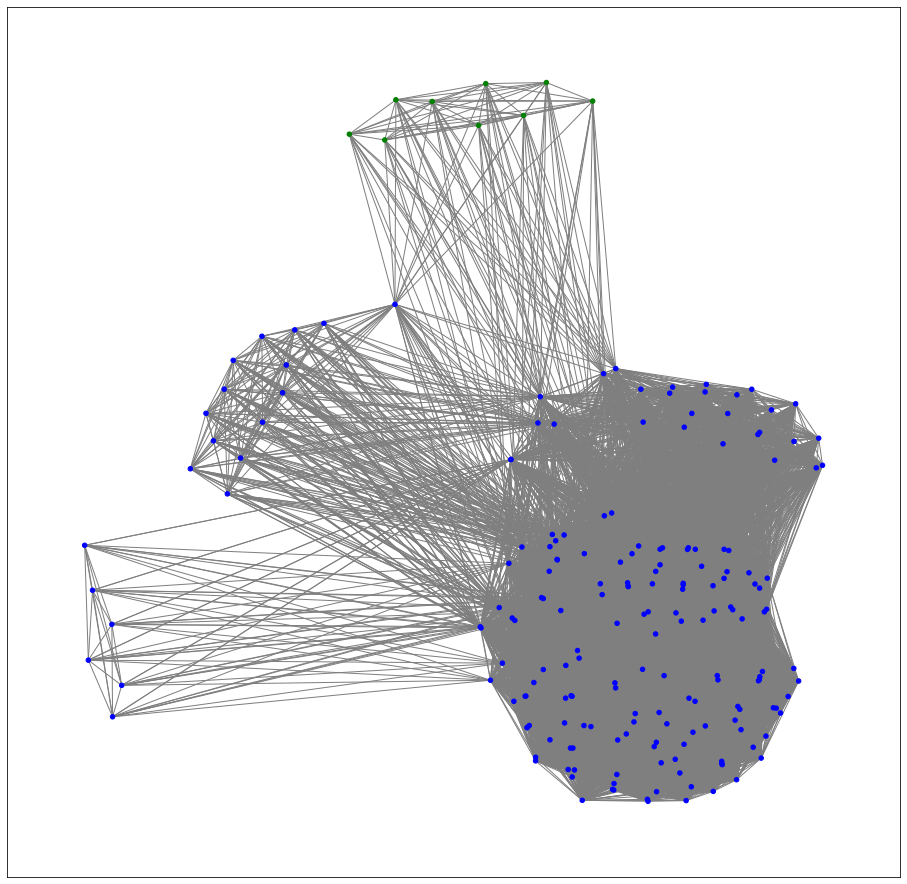

In [79]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# # load the karate club graph
# G = nx.draw_networkx(graph, with_labels=False, node_size = 20, edge_color="tab:gray")
# #first compute the best partition
# partition = community_louvain.best_partition(G)

# # draw the graph
# pos = nx.spring_layout(G)
# # color the nodes according to their partition
# cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
# nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
#                        cmap=cmap, node_color=list(partition.values()))
# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.show()
plt.figure(3,figsize=(16,16)) 

def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg
    
# find communities in the graph
c = girvan_newman(graph.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))


# plot the communities
color_map = []
for node in graph:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]:
        color_map.append('green')
    elif node in node_groups[2]:
        color_map.append('red')
    elif node in node_groups[3]:
        color_map.append('cyan')
    elif node in node_groups[4]:
        color_map.append('magenta')
    else: 
        color_map.append('black')  

nx.draw_networkx(graph, node_color=color_map, with_labels=False, node_size = 20, edge_color="tab:gray")
plt.show()

In [ ]:
print(len(node_groups))

nx.number_connected_components(graph)

2


1